In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch

from torchvision import models, transforms
import warnings
# Or if you are using > Python 3.11:
warnings.filterwarnings('ignore')

In [8]:
# configure all the paths to images and annotations
DATA_DIR = 'oral cancer.v3i.tensorflow'
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'valid')


test_annotations = pd.read_csv(os.path.join(TEST_DIR, '_annotations.csv'))
train_annotations = pd.read_csv(os.path.join(TRAIN_DIR, '_annotations.csv'))
valid_annotations = pd.read_csv(os.path.join(VALID_DIR, '_annotations.csv'))

In [9]:
def filter_annotations(annotations, img_dir):
    """
    Filters the annotations to include only images present in the specified directory.
    
    Args:
        annotations (pandas.DataFrame): The annotations DataFrame.
        img_dir (str): The directory path containing the images.
        
    Returns:
        pandas.DataFrame: The filtered annotations DataFrame.
    """
    image_files = [f for f in os.listdir(img_dir)]
    annotations = annotations[annotations['filename'].isin(image_files)]
    annotations = annotations.drop_duplicates(subset=['filename'])
    return annotations

test_annotations = filter_annotations(test_annotations, os.path.join(TEST_DIR))
train_annotations = filter_annotations(train_annotations, os.path.join(TRAIN_DIR))
valid_annotations = filter_annotations(valid_annotations, os.path.join(VALID_DIR))

In [10]:
# the size of test, train & valid images are 423, 6411, 603 respectively
print(len(test_annotations))
print(len(train_annotations))
print(len(valid_annotations))

423
6411
603


In [11]:
def separate_images(annotations):
    """
    Separates the images into cancerous and non-cancerous groups based on the annotations.

    Args:
        annotations (pandas.DataFrame): The annotations DataFrame.

    Returns:
        tuple: A tuple containing two lists:
            cancerous (list): A list of cancerous image paths.
            non_cancerous (list): A list of non-cancerous image paths.
    """
    cancerous = []
    non_cancerous = []

    for _, row in annotations.iterrows():
        image_path = os.path.join(row['filename'])
        if row['class'] == "cancer":  # Cancerous
            cancerous.append(image_path)
        elif row["class"] == "no cancer":  # Non-cancerous
            non_cancerous.append(image_path)

    return cancerous, non_cancerous

test_cancerous, test_non_cancerous = separate_images(test_annotations)
train_cancerous, train_non_cancerous = separate_images(train_annotations)
valid_cancerous, valid_non_cancerous = separate_images(valid_annotations)

# print sizes of cancerous and non-cancerous images
print(len(test_cancerous), len(test_non_cancerous))
print(len(train_cancerous), len(train_non_cancerous))
print(len(valid_cancerous), len(valid_non_cancerous))

203 220
3226 3185
295 308


In [12]:
cancerous_image_paths = [os.path.join(TEST_DIR, img) for img in test_cancerous] + [os.path.join(VALID_DIR, img) for img in valid_cancerous] + [os.path.join(TRAIN_DIR, img) for img in train_cancerous] 
non_cancerous_image_paths = [os.path.join(TEST_DIR, img) for img in test_non_cancerous] + [os.path.join(VALID_DIR, img) for img in valid_non_cancerous] + [os.path.join(TRAIN_DIR, img) for img in train_non_cancerous]

In [14]:
# load the pre-trained model
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Feature Extraction**

In [15]:
from PIL import Image

# Define the transformations for the input images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Iterate over the image paths
def find_features(paths):
    features = []
    for path in paths:
        # Load the image
        image = Image.open(path)

        # Apply the transformations
        image_tensor = transform(image)

        # Add a batch dimension
        image_tensor = image_tensor.unsqueeze(0)

        # Perform forward pass through the model
        with torch.no_grad():
            output = resnet50(image_tensor)

        # Extract the features from the desired layer
        # Here, we'll use the output from the last layer before the classification layer
        feature = output.squeeze().detach().numpy()

        # Append the feature to the list
        features.append(feature)
    return features
cancerous_features = find_features(cancerous_image_paths)
non_cancerous_features = find_features(non_cancerous_image_paths)

# **Preprocess the Features**

In [16]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
cancerous_features_scaled = scaler.fit_transform(cancerous_features)
non_cancerous_features_scaled = scaler.transform(non_cancerous_features)

# **Split the Data**

In [17]:
from sklearn.model_selection import train_test_split

# Combine features and labels
X = np.concatenate((cancerous_features_scaled, non_cancerous_features_scaled), axis=0)
y = np.concatenate((np.ones(len(cancerous_features)), np.zeros(len(non_cancerous_features))), axis=0)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Choose a Classification Algorithm**

In [18]:
from xgboost import XGBClassifier

# We will use the XGBoost classifier for this problem, with the best hyperparameters
# Initialize the XGBoost classifier
# model = XGBClassifier(random_state=42)

# **Hyperparameter Tuning**

In [19]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the hyperparameter search space
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform randomized search
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# **Model Training**

In [20]:
# Train the model with the best hyperparameters
model = XGBClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# **Model Evaluation**

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

Accuracy: 0.847
Precision: 0.841
Recall: 0.863
F1-Score: 0.852
AUC-ROC: 0.932


# **Ensemble Methods**

In [22]:
# ensemble accuracy is lesser than the XGB model's
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# Initialize individual models
xgb_model = XGBClassifier(**best_params, random_state=42)
lr_model = LogisticRegression(random_state=42)

# Create a voting ensemble without the SVM model
ensemble = VotingClassifier(estimators=[('xgb', xgb_model), ('lr', lr_model)], voting='soft')

# Train the ensemble
ensemble.fit(X_train, y_train)

# Evaluate the ensemble on the test set
y_pred_ensemble = ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {ensemble_accuracy:.3f}")

Ensemble Accuracy: 0.817


# **Regularization and Feature Selection**

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

# Regularized logistic regression with feature selection
logistic = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', random_state=42)
logistic.fit(X_train, y_train)

# Get the selected features
selected_features = SelectFromModel(logistic, prefit=True).get_support()
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Train and evaluate the model on the selected features 
model.fit(X_train_selected, y_train)
y_pred_selected = model.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_pred_selected)
print(f"Accuracy with Feature Selection: {selected_accuracy:.3f}")

Accuracy with Feature Selection: 0.839


# **Model Interpretation and Explainability:**

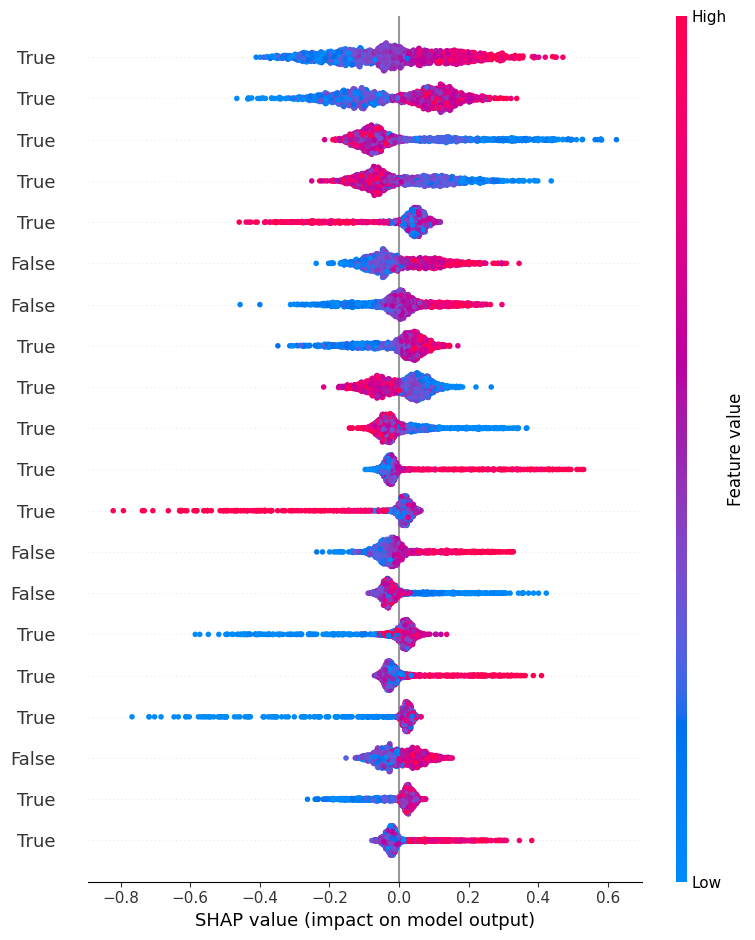

In [29]:
import shap

# Initialize the SHAP explainer c
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_selected)

# Visualize feature importance
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features)

# **Save the Model**

In [31]:
import pickle

# Assuming you have trained your model and it's stored in the 'model' variable
with open('image_classifier_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the saved model
#with open('image_classifier_model.pkl', 'rb') as f:
    #loaded_model = pickle.load(f)